# Generalizations to the Ptychographic Iterative Engine

In general, ptychography describes a family of reconstruction algorithms which attempt to find the object operator $\hat{O}_j = O_{\boldsymbol{r}-\boldsymbol{R}_j}$ and probe $\left| P \right \rangle$ state which reproduce measured diffraction intensities:

$$
I_{j \boldsymbol{q}} = \left| \left \langle \boldsymbol{q} \right| \hat{O}_j \left| P \right \rangle \right|^2
$$

The ptychographic iterative engine (PIE) is an iterative technique which modifies the current exit wave $\psi_{j \boldsymbol{r}}$ estimate by replacing its Fourier amplitude with the square root of the measured diffraction intensity.

The three steps in the various different PIE formulations we'll consider are given by:
1. Overlap-Projection Constraint, between Object(s) and Probe(s)
2. Fourier-Projection Constraint, between Exit-Wave and Measured Diffraction Intensities
3. Gradient-Descent Update for Object(s) and (optionally) Probe(s)

Here, we review the following extensions:

i. [Regularized PIE](https://doi.org/10.1364/OPTICA.4.000736)   
ii. [Mixed-States PIE](https://doi.org/10.1038/s41467-020-16688-6)  
iii. [Multislice PIE](https://doi.org/10.1364/JOSAA.29.001606)  
iv. Simultaneous reconstruction of multiple sets of diffraction intensities 

Additionally, we investigate probe-position correction for the case of uncertainty in the location of the probes.

# Weak-Phase Objects

We demonstrate the first two algorithms using a dummy weak-phase object (modeled using a zero-thickness PotentialArray).  
_Note:_ We use an image with aspect ratio != 1, to demonstrate the need for a moving-window reconstruction in realistic scenarios

## Periodic Reconstruction

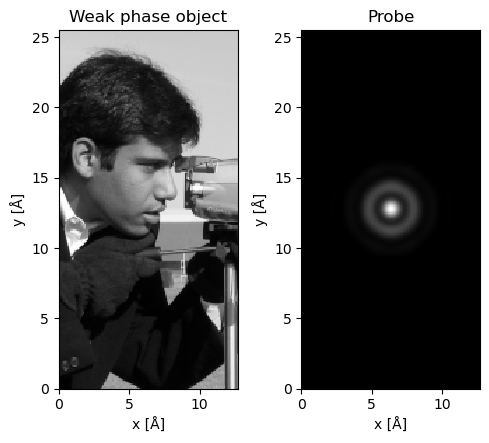

In [1]:
import numpy as np
from skimage import data
from abtem import GridScan, PixelatedDetector, PotentialArray, Probe
import matplotlib.pyplot as plt

image = data.camera().astype(np.float32)
image = image[50:50+2*128,170:170+128].T[:,::-1]
image = image / image.max() * 1e3
potential = PotentialArray(image[None], [0.], sampling=.1)

probe = Probe(semiangle_cutoff=20, energy=80e3, defocus=300,Cs=1e6)
probe.grid.match(potential)

fig,(ax1,ax2)= plt.subplots(1,2, figsize=(5,5))
potential.project().show(ax=ax1, title='Weak phase object')
probe.show(ax=ax2, title='Probe')

fig.tight_layout()

We simulate diffraction patterns covering the entire (periodic) test object:

In [2]:
gridscan_start        = np.array([0,0])
gridscan_end          = potential.extent - gridscan_start
gridscan              = GridScan(gridscan_start, gridscan_end, sampling=1,endpoint=False)
pixelated_detector    = PixelatedDetector(max_angle=None)
pixelated_measurement = probe.scan(gridscan, pixelated_detector, potential)

Scan:   0%|          | 0/338 [00:00<?, ?it/s]

We start by using the `RegularizedPtychographicOperator` object from `abtem.reconstruct`.  
This has various options, but at the very least needs to be initialized using:  
- A `Measurement` object (or array dirrectly) representing the set of diffraction intensities  
- The `energy` the experiment was carried out and the `semiangle_cutoff` for our initial probe-guess  
  - We could pass `defocus` and `Cs` aswell - but one of the strengths of PIE is reconstructing the probe aberrations, so we deliberately omit these and use a twice smaller `semiangle_cutoff` as the simulation  
  
_Note:_ The initialization further accepts a parameters dictionary, with the properties below pertaining to the simulation/experimental conditions.  
If you're passing a `Measurement` object, most of these will be automatically detected, but here we specify `object_px_padding`:(0,0) to indicate we're interested in a periodic reconstruction.

In [5]:
from abtem.reconstruct import experimental_symbols, reconstruction_symbols

experimental_symbols

('rotation_angle',
 'scan_step_sizes',
 'angular_sampling',
 'background_counts_cutoff',
 'counts_scaling_factor',
 'grid_scan_shape',
 'object_px_padding')

The object then exposes two main methods:
1. `.preprocess()`, which prepares the reconstruction
2. `.reconstruct()`, which performs the ptychographic reconstruction, using the requested reconstruction parameters.  
We'll see these in action as we go through this notebook, but for now we can use the default values given below:

In [7]:
reconstruction_symbols

{'alpha': 1.0,
 'beta': 1.0,
 'object_step_size': 1.0,
 'probe_step_size': 1.0,
 'position_step_size': 1.0,
 'step_size_damping_rate': 0.995,
 'pre_position_correction_update_steps': None,
 'pre_probe_correction_update_steps': None}

In [8]:
from abtem.reconstruct import RegularizedPtychographicOperator

periodic_simulation_ptycho_operator = RegularizedPtychographicOperator(pixelated_measurement,
                                                                       energy=80e3,
                                                                       semiangle_cutoff=10,
                                                                       device='gpu',
                                                                       parameters={'object_px_padding':(0,0)}).preprocess()

objects_01, probes_01, positions_01, sse_01 = periodic_simulation_ptycho_operator.reconstruct(max_iterations = 20,
                                                                                              verbose=True,
                                                                                              random_seed=1,
                                                                                              return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 6760 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

----Iteration 0 , SSE = 8.816e-07
----Iteration 1 , SSE = 8.267e-07
----Iteration 2 , SSE = 7.420e-07
----Iteration 3 , SSE = 4.130e-07
----Iteration 4 , SSE = 1.242e-07
----Iteration 5 , SSE = 5.022e-08
----Iteration 6 , SSE = 2.741e-08
----Iteration 7 , SSE = 1.746e-08
----Iteration 8 , SSE = 1.198e-08
----Iteration 9 , SSE = 8.942e-09
----Iteration 10, SSE = 6.795e-09
----Iteration 11, SSE = 5.170e-09
----Iteration 12, SSE = 3.934e-09
----Iteration 13, SSE = 2.895e-09
----Iteration 14, SSE = 2.000e-09
----Iteration 15, SSE = 1.229e-09
----Iteration 16, SSE = 8.117e-10
----Iteration 17, SSE = 5.742e-10
----Iteration 18, SSE = 4.121e-10
----Iteration 19, SSE = 3.146e-10


_Note:_ Since we specified `verbose=True`, the reconstruction first prints the steps it will take, as-well as the error of each iteration.

Let's investigate our reconstructed object and probe:

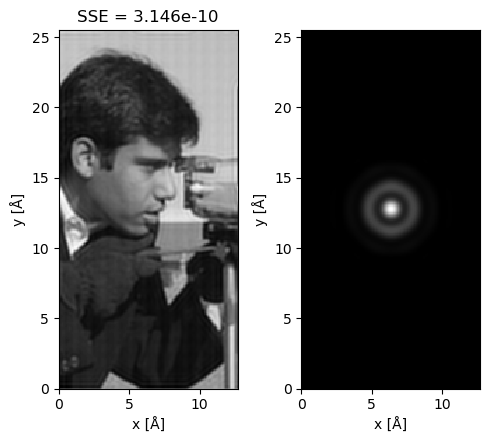

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (5,5))
objects_01[-1].angle().show(ax=ax1,title=f"SSE = {float(sse_01[-1]):.3e}")
probes_01[-1].intensity().show(ax=ax2)
fig.tight_layout()

Indeed, the algorithm properly accounted for all probe aberrations, and achieved a fairly good reconstruction quality!  
_Note:_ The object we're trying to reconstruct however, is not in-fact periodic and while the redundancy in the dataset mostly corrected for this, we can see evidence of periodicity on the center-right of the image (shadow due to the darker 'hair' on the center-left side of the image)

## Padded Reconstruction  
The obvious solution is to pad our image and perform the scanning-probe simulations again

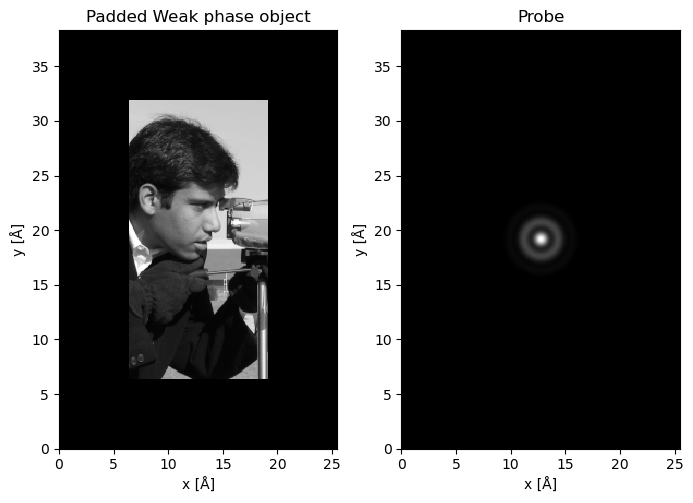

In [10]:
padded_image     = np.pad(image,((64,64),(64,64)))
padded_potential = PotentialArray(padded_image[None], [0.], sampling=.1)

padded_probe = Probe(semiangle_cutoff=20, energy=80e3, defocus=300,Cs=1e6)
padded_probe.grid.match(padded_potential)

fig,(ax1,ax2)= plt.subplots(1,2, figsize=(7,5))
padded_potential.project().show(ax=ax1, title='Padded Weak phase object')
padded_probe.show(ax=ax2, title='Probe')

fig.tight_layout()

In [11]:
gridscan_start_padded         = np.array(padded_potential.sampling)*(64,64)
gridscan_end_padded           = padded_potential.extent - gridscan_start_padded
gridscan_padded               = GridScan(gridscan_start_padded, gridscan_end_padded, sampling=1,endpoint=True)
pixelated_detector_padded     = PixelatedDetector(max_angle=None)
pixelated_measurement_padded  = padded_probe.scan(gridscan_padded, pixelated_detector_padded, padded_potential)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

We can use a nearly-identical reconstruction setup, but here we again specify the non-zero padding (this is not necessary for experimental datasets)

In [12]:
nonperiodic_simulation_ptycho_operator = RegularizedPtychographicOperator(pixelated_measurement_padded,
                                                                          energy=80e3,
                                                                          semiangle_cutoff=10,
                                                                          device='gpu',
                                                                          parameters={'object_px_padding':(64,64)}).preprocess()

objects_02, probes_02, positions_02, sse_02 = nonperiodic_simulation_ptycho_operator.reconstruct(max_iterations = 20,
                                                                                                 verbose=True,
                                                                                                 random_seed=1,
                                                                                                 return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 7560 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0 , SSE = 3.534e-07
----Iteration 1 , SSE = 2.467e-07
----Iteration 2 , SSE = 1.937e-07
----Iteration 3 , SSE = 9.388e-08
----Iteration 4 , SSE = 3.769e-08
----Iteration 5 , SSE = 2.254e-08
----Iteration 6 , SSE = 1.619e-08
----Iteration 7 , SSE = 1.230e-08
----Iteration 8 , SSE = 9.538e-09
----Iteration 9 , SSE = 7.837e-09
----Iteration 10, SSE = 6.479e-09
----Iteration 11, SSE = 5.737e-09
----Iteration 12, SSE = 4.963e-09
----Iteration 13, SSE = 4.267e-09
----Iteration 14, SSE = 3.699e-09
----Iteration 15, SSE = 3.241e-09
----Iteration 16, SSE = 2.822e-09
----Iteration 17, SSE = 2.434e-09
----Iteration 18, SSE = 2.206e-09
----Iteration 19, SSE = 2.019e-09


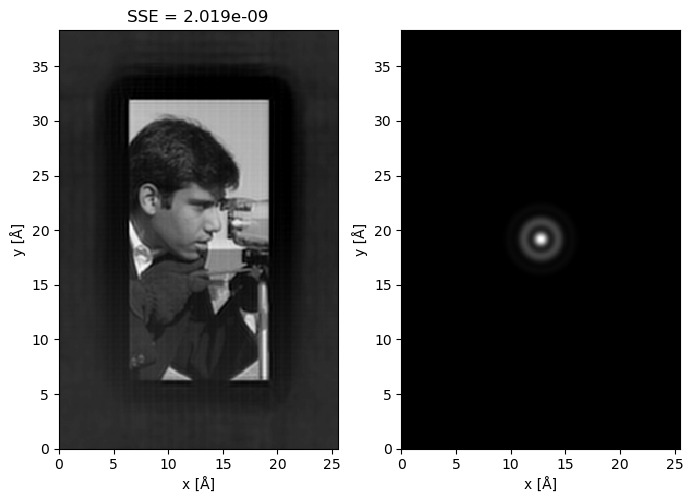

In [13]:
vmin = np.amin(np.angle(objects_02[-1].array[64:-64,64:-64]))
vmax = np.amax(np.angle(objects_02[-1].array[64:-64,64:-64]))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7,5))
objects_02[-1].angle().show(ax=ax1,vmin=vmin,vmax=vmax,title=f"SSE = {float(sse_02[-1]):.3e}")
probes_02[-1].intensity().show(ax=ax2)
fig.tight_layout()

Indeed, we achieve a superior reconstruction, as evidenced by the lower error - as-well as the absence of the aforementioned 'shadow' in the center-right of the image

### Side-note:

In the above reconstructions, we initialized the objects array with `1.0j` and the probe array with a `Probe` object using the specified `energy` and `semiangle_cutoff`.  
We can also directly input `objects` and `probes` parameters to our reconstruction object during initialization. This is particularly useful for restarting calculations:

In [14]:
nonperiodic_simulation_ptycho_operator_02 = RegularizedPtychographicOperator(pixelated_measurement_padded,
                                                                             energy=80e3,
                                                                             objects= objects_02[-1].array,
                                                                             probes = probes_02[-1].array,
                                                                             device='gpu',
                                                                             parameters={'object_px_padding':(64,64)}).preprocess()

objects_03, probes_03, positions_03, sse_03 = nonperiodic_simulation_ptycho_operator_02.reconstruct(max_iterations = 1,
                                                                                                    random_seed=1,
                                                                                                    verbose=True,
                                                                                                    return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 378 steps
--Probe correction is enabled


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0, SSE = 1.868e-09


## Fixed-Angular Sampling CBED Patterns

Notice that the simulations above used `max_angle=None` and `resample=False`. This results in ideal real-space resolution, but is unrealistic for experiments, where the detector pixel-spacing is determined by other factors such as the camera length. This also inherits the aspect ratio of the potential, resulting in non-uniform angular spacing for our CBED patterns.

To simulate a more realistic scenario, we downsample to a (larger) uniform angular spacing, e.g. here we use 1.5x the maximum angular sampling set by the object's extent 

In [15]:
pixelated_detector_padded_downsampled     = PixelatedDetector(max_angle=None,
                                                              resample=(np.max(padded_probe.angular_sampling)*3/2,)*2)
pixelated_measurement_padded_downsampled  = padded_probe.scan(gridscan_padded, pixelated_detector_padded_downsampled, padded_potential)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

Let's visualize our two PACBED patterns, which should be identical subject to downsampling errors.

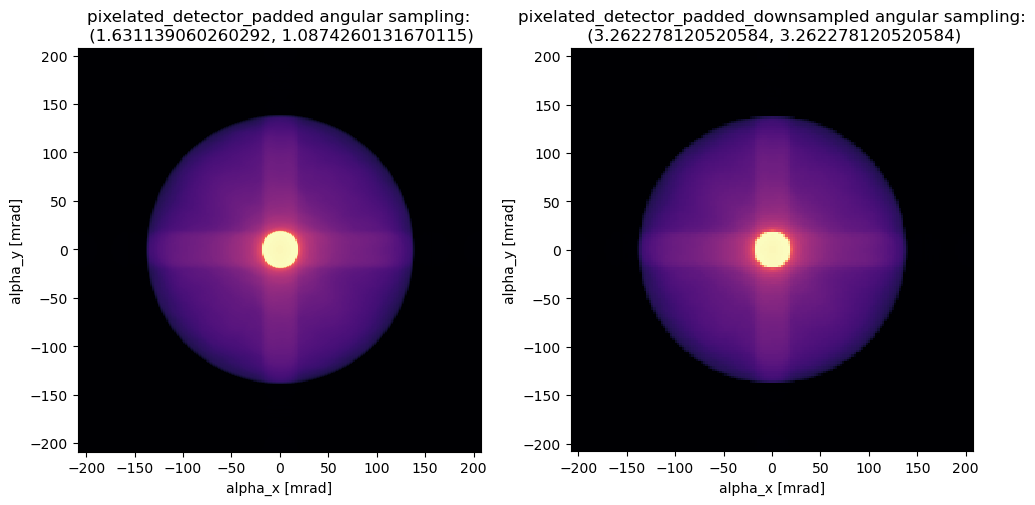

In [16]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

pixelated_measurement_padded.mean(axis=(0,1)).show(power=0.125,
                                  ax=ax1,cmap='magma',
                                  title=f'pixelated_detector_padded angular sampling:\n {padded_probe.angular_sampling}')
pixelated_measurement_padded_downsampled.mean(axis=(0,1)).show(power=0.125,
                                              ax=ax2,cmap='magma',
                                              title=f'pixelated_detector_padded_downsampled angular sampling:\n {(np.max(padded_probe.angular_sampling)*2,)*2}')
fig.tight_layout()

We can check that both CBED patterns give the same spatial resolution (given by `padded_potential.sampling`):

In [18]:
from abtem.utils import energy2wavelength

pixelated_measurement_padded_sampling = tuple(energy2wavelength(80e3)*1000/(cal.sampling * pixels) 
                                              for cal,pixels 
                                              in zip(pixelated_measurement_padded.calibrations[-2:],pixelated_measurement_padded.shape[-2:]))

pixelated_measurement_padded_downsampled_sampling = tuple(energy2wavelength(80e3)*1000/(cal.sampling * pixels) 
                                                          for cal,pixels 
                                                          in zip(pixelated_measurement_padded_downsampled.calibrations[-2:],pixelated_measurement_padded_downsampled.shape[-2:]))

print(f'''
    pixelated_measurement sampling: {pixelated_measurement_padded_sampling}
    pixelated_measurement_downsampled sampling: {pixelated_measurement_padded_downsampled_sampling}
    object sampling: {padded_potential.sampling}''')


    pixelated_measurement sampling: (0.10000000149011612, 0.10000000397364295)
    pixelated_measurement_downsampled sampling: (0.09980506971333228, 0.09980506971333228)
    object sampling: (0.1, 0.10000000000000002)


However, our downsampled CBED patterns cover only a small extent of the original object:

In [19]:
pixelated_measurement_padded_extent = tuple(sampling*pixels for sampling,pixels 
                                      in zip(pixelated_measurement_padded_sampling,pixelated_measurement_padded.shape[-2:]))

pixelated_measurement_padded_downsampled_extent = tuple(sampling*pixels for sampling,pixels 
                                                  in zip(pixelated_measurement_padded_downsampled_sampling,pixelated_measurement_padded_downsampled.shape[-2:]))

print(f'''
    pixelated_measurement extent: {pixelated_measurement_padded_extent}
    pixelated_measurement_downsampled extent: {pixelated_measurement_padded_downsampled_extent}
    object extent: {padded_potential.extent}''')


    pixelated_measurement extent: (25.600000381469727, 38.40000152587889)
    pixelated_measurement_downsampled extent: (17.06666692097982, 17.06666692097982)
    object extent: (25.6, 38.400000000000006)


As such, we'll need to tile our object with a CBED-sized probe.  
More specifically, we'll call this moving window our region of interest (ROI) and call its dimensions `(R,S)`, which we'll require are at-least as large as our CBED pattern dimensions `(M,N)`.  

_Note:_ The probe ROI needs to be large enough to include most of the probe, with minimal boundary artifacts.

_Note:_ We will typically work with square CBED patterns, resulting in $(R,R)\ge (M,M)$, but we allow non-square dimensions to support the simulated full-extent CBED patterns.

Our object has dimensions $(P,Q) \ge (R,S)$ which cover the entire padded object.

E.g. we can use a square ROI probe guess using the same extent as our CBED patterns above:

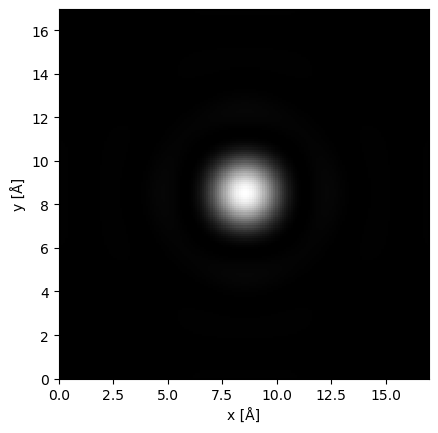

In [20]:
probe_roi    = Probe(semiangle_cutoff=10, energy=80e3,
                     sampling = pixelated_measurement_padded_downsampled_sampling,
                     gpts     = pixelated_measurement_padded_downsampled.shape[-2:])

probe_roi.show();

Most of our probe fits inside the ROI, so let's go ahead and reconstruct using these dimensions.  
_Note:_ If this wasn't the case, the object below also accepts a `region_of_interest_shape` parameter and zero-pads the CBED patterns accordingly

In [21]:
fixed_angular_sampling_ptycho_operator = RegularizedPtychographicOperator(pixelated_measurement_padded_downsampled,
                                                                          energy=80e3,
                                                                          semiangle_cutoff=10,
                                                                          device='gpu',
                                                                          parameters={'object_px_padding':(64,64)}).preprocess()

objects_04, probes_04, positions_04, sse_04 = fixed_angular_sampling_ptycho_operator.reconstruct(max_iterations = 20,
                                                                                                 verbose=True,
                                                                                                 random_seed=1,
                                                                                                 return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 7560 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.198e-06
----Iteration 1 , SSE = 4.626e-07
----Iteration 2 , SSE = 1.917e-07
----Iteration 3 , SSE = 1.098e-07
----Iteration 4 , SSE = 8.283e-08
----Iteration 5 , SSE = 6.528e-08
----Iteration 6 , SSE = 5.512e-08
----Iteration 7 , SSE = 4.990e-08
----Iteration 8 , SSE = 4.495e-08
----Iteration 9 , SSE = 4.234e-08
----Iteration 10, SSE = 3.777e-08
----Iteration 11, SSE = 3.603e-08
----Iteration 12, SSE = 3.410e-08
----Iteration 13, SSE = 3.220e-08
----Iteration 14, SSE = 3.132e-08
----Iteration 15, SSE = 3.032e-08
----Iteration 16, SSE = 2.917e-08
----Iteration 17, SSE = 2.803e-08
----Iteration 18, SSE = 2.829e-08
----Iteration 19, SSE = 2.798e-08


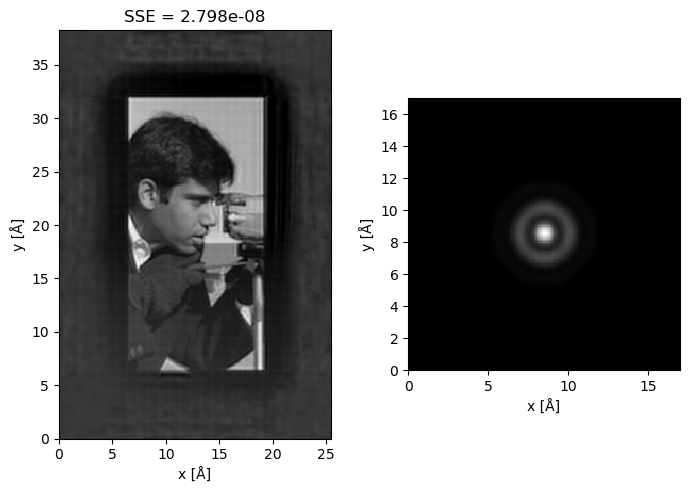

In [22]:
vmin = np.amin(np.angle(objects_04[-1].array[64:-64,64:-64]))
vmax = np.amax(np.angle(objects_04[-1].array[64:-64,64:-64]))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7,5))
objects_04[-1].angle().show(ax=ax1,vmin=vmin,vmax=vmax,title=f"SSE = {float(sse_04[-1]):.3e}")
probes_04[-1].intensity().show(ax=ax2)
fig.tight_layout()

Our reconstruction error is (naturally) larger than in the ideal case before, but the results are certainly satisfactory.

## Limited Scattering Angles

So far, we've used `max_angle=None`, however our experimental detector geometry might be limited to a certain maximum angle:

In [23]:
pixelated_detector_padded_limited     = PixelatedDetector(max_angle=103,resample='uniform')
pixelated_measurement_padded_limited  = padded_probe.scan(gridscan_padded, pixelated_detector_padded_limited, padded_potential)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

This will limit our spatial sampling:

pixelated_measurement_padded_limited sampling: (0.20000000298023224, 0.20000000298023224)


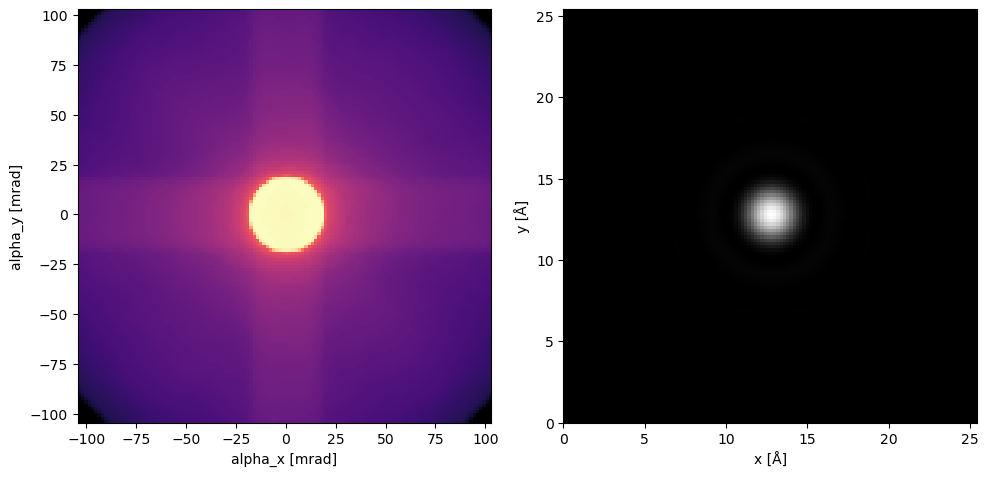

In [25]:
pixelated_measurement_padded_limited_sampling = tuple(energy2wavelength(80e3)*1000/(cal.sampling * pixels) 
                                                      for cal,pixels 
                                                      in zip(pixelated_measurement_padded_limited.calibrations[-2:],pixelated_measurement_padded_limited.shape[-2:]))

print(f'pixelated_measurement_padded_limited sampling: {pixelated_measurement_padded_limited_sampling}')

probe_roi_limited    = Probe(semiangle_cutoff=10, energy=80e3,
                             sampling = pixelated_measurement_padded_limited_sampling,
                             gpts     = pixelated_measurement_padded_limited.shape[-2:])

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
pixelated_measurement_padded_limited.mean(axis=(0,1)).show(power=0.125,cmap='magma',ax=ax1);
probe_roi_limited.show(ax=ax2)
fig.tight_layout()

In [26]:
limited_scattering_angles_ptycho_operator = RegularizedPtychographicOperator(pixelated_measurement_padded_limited,
                                                                             energy=80e3,
                                                                             semiangle_cutoff=10,
                                                                             device='gpu',
                                                                             parameters={'object_px_padding':(32,32)}).preprocess()

objects_05, probes_05, positions_05, sse_05 = limited_scattering_angles_ptycho_operator.reconstruct(max_iterations = 20,
                                                                                                    verbose=True,
                                                                                                    random_seed=1,
                                                                                                    return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 7560 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0 , SSE = 2.133e-06
----Iteration 1 , SSE = 1.376e-06
----Iteration 2 , SSE = 8.032e-07
----Iteration 3 , SSE = 3.187e-07
----Iteration 4 , SSE = 1.624e-07
----Iteration 5 , SSE = 1.101e-07
----Iteration 6 , SSE = 8.214e-08
----Iteration 7 , SSE = 6.832e-08
----Iteration 8 , SSE = 5.565e-08
----Iteration 9 , SSE = 4.850e-08
----Iteration 10, SSE = 4.208e-08
----Iteration 11, SSE = 3.782e-08
----Iteration 12, SSE = 3.432e-08
----Iteration 13, SSE = 3.138e-08
----Iteration 14, SSE = 2.893e-08
----Iteration 15, SSE = 2.686e-08
----Iteration 16, SSE = 2.521e-08
----Iteration 17, SSE = 2.332e-08
----Iteration 18, SSE = 2.212e-08
----Iteration 19, SSE = 2.089e-08


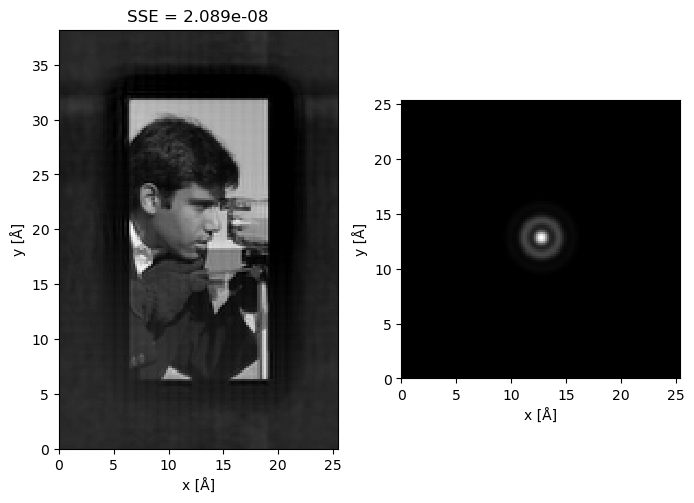

In [27]:
vmin = np.amin(np.angle(objects_05[-1].array[32:-32,32:-32]))
vmax = np.amax(np.angle(objects_05[-1].array[32:-32,32:-32]))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7,5))
objects_05[-1].angle().show(ax=ax1,vmin=vmin,vmax=vmax,title=f"SSE = {float(sse_05[-1]):.3e}")
probes_05[-1].intensity().show(ax=ax2)
fig.tight_layout()

Even though our object array is twice as small, since all our scattering information was maintained in the CBED region we cropped to and due to the sub-pixel corrective power of the algorithm, we achieve near identical reconstruction quality!

## Position Correction

We also investigate the common experimental case where the probe positions are not known precisely (e.g. due to drift during acquisition).  
In order to simulate the uncertainty in the probe positions, we create a custom-positions scan by adding small random perturbations to our gridscan positions.

In [32]:
from abtem.measure import Measurement
from abtem.scan import PositionScan

positions_random      = gridscan_padded.get_positions()
positions_random     += (np.random.random(positions_random.shape)*2 -1)/5
randomscan_padded     = PositionScan(positions_random)

pixelated_measurement_random  = padded_probe.scan(randomscan_padded, pixelated_detector_padded_downsampled, padded_potential)
pixelated_measurement_random  = Measurement(pixelated_measurement_random.array.reshape(pixelated_measurement_padded_downsampled.shape),
                                            pixelated_measurement_padded_downsampled.calibrations)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

We first see how well the reconstruction algorithm performs on its own (assuming a fixed grid of positions)

In [39]:
position_correction_ptycho_operator = RegularizedPtychographicOperator(pixelated_measurement_random,
                                                                       energy=80e3,
                                                                       semiangle_cutoff=10,
                                                                       device='gpu',
                                                                       parameters={'object_px_padding':(64,64)}).preprocess()

objects_06, probes_06, positions_06, sse_06 = position_correction_ptycho_operator.reconstruct(max_iterations = 20,
                                                                                              verbose=True,
                                                                                              random_seed=1,
                                                                                              return_iterations=True,
                                                                                              parameters={'step_size_damping_rate':0.75})

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 7560 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.202e-06
----Iteration 1 , SSE = 4.957e-07
----Iteration 2 , SSE = 2.471e-07
----Iteration 3 , SSE = 1.651e-07
----Iteration 4 , SSE = 1.336e-07
----Iteration 5 , SSE = 1.143e-07
----Iteration 6 , SSE = 1.036e-07
----Iteration 7 , SSE = 9.820e-08
----Iteration 8 , SSE = 9.299e-08
----Iteration 9 , SSE = 8.995e-08
----Iteration 10, SSE = 8.715e-08
----Iteration 11, SSE = 8.645e-08
----Iteration 12, SSE = 8.544e-08
----Iteration 13, SSE = 8.416e-08
----Iteration 14, SSE = 8.358e-08
----Iteration 15, SSE = 8.302e-08
----Iteration 16, SSE = 8.273e-08
----Iteration 17, SSE = 8.242e-08
----Iteration 18, SSE = 8.224e-08
----Iteration 19, SSE = 8.205e-08


Our error is substantially larger than before.  
Let's see if position correction can help:

In [38]:
position_correction_ptycho_operator_02 = RegularizedPtychographicOperator(pixelated_measurement_random,
                                                                          energy=80e3,
                                                                          semiangle_cutoff=10,
                                                                          device='gpu',
                                                                          parameters={'object_px_padding':(64,64)}).preprocess()

objects_07, probes_07, positions_07, sse_07  = position_correction_ptycho_operator_02.reconstruct(max_iterations = 20,
                                                                                                  verbose=True,
                                                                                                  random_seed=1,
                                                                                                  return_iterations=True,
                                                                                                  parameters={'pre_position_correction_update_steps':
                                                                                                               position_correction_ptycho_operator._num_diffraction_patterns*5,
                                                                                                              'position_step_size':1,
                                                                                                              'step_size_damping_rate':0.75})

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 1890 steps
--Regularized PIE with position correction for 5670 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.202e-06
----Iteration 1 , SSE = 4.957e-07
----Iteration 2 , SSE = 2.471e-07
----Iteration 3 , SSE = 1.651e-07
----Iteration 4 , SSE = 1.336e-07
----Iteration 5 , SSE = 1.840e-07
----Iteration 6 , SSE = 1.233e-07
----Iteration 7 , SSE = 1.127e-07
----Iteration 8 , SSE = 1.128e-07
----Iteration 9 , SSE = 9.416e-08
----Iteration 10, SSE = 1.014e-07
----Iteration 11, SSE = 9.237e-08
----Iteration 12, SSE = 9.449e-08
----Iteration 13, SSE = 8.502e-08
----Iteration 14, SSE = 8.674e-08
----Iteration 15, SSE = 8.250e-08
----Iteration 16, SSE = 8.124e-08
----Iteration 17, SSE = 7.878e-08
----Iteration 18, SSE = 7.981e-08
----Iteration 19, SSE = 7.979e-08


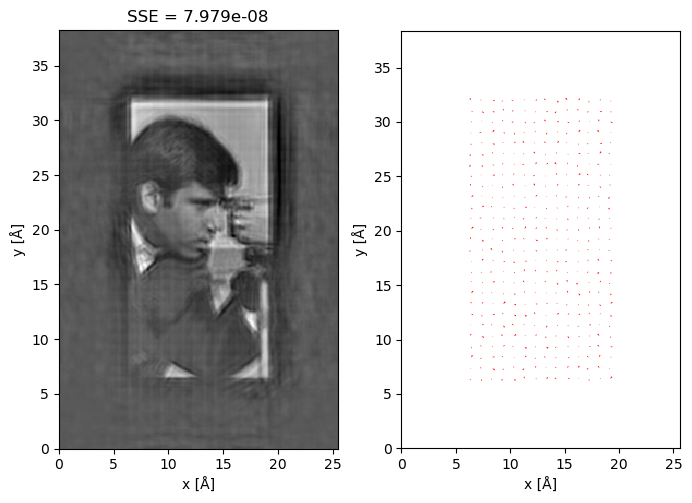

In [42]:
vmin = np.amin(np.angle(objects_07[-1].array[64:-64,64:-64]))
vmax = np.amax(np.angle(objects_07[-1].array[64:-64,64:-64]))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7,5))
objects_07[-1].angle().show(ax=ax1,vmin=vmin,vmax=vmax,title=f"SSE = {float(sse_07[-1]):.3e}")

ax2.quiver(*zip(*np.hstack((positions_random,positions_07[-1]-positions_random))),facecolors='r',scale=1,scale_units='xy')
ax2.set_aspect('equal')
ax2.set(xlabel='x [Å]',ylabel='y [Å]',xlim=(0,padded_potential.extent[0]),ylim=(0,padded_potential.extent[1]))
fig.tight_layout()

This is admiteddly not an impressive improvement, but the arrow plot suggests the positions have been recovered reasonably.

## Mixed-States

The partial coherence of the illumination probe in experimentally-obtained ptychographic datasets can often reduce the signal-to-noise of the reconstruction.  
To account for this we can use a mixed-states PIE algorithm to decompose the probe wavefunction into a mixed quantum state.

In order to simulate an example to test our algorithm, we implement a custom `CTF` function to separate our probe into radial bins (in reciprocal space):

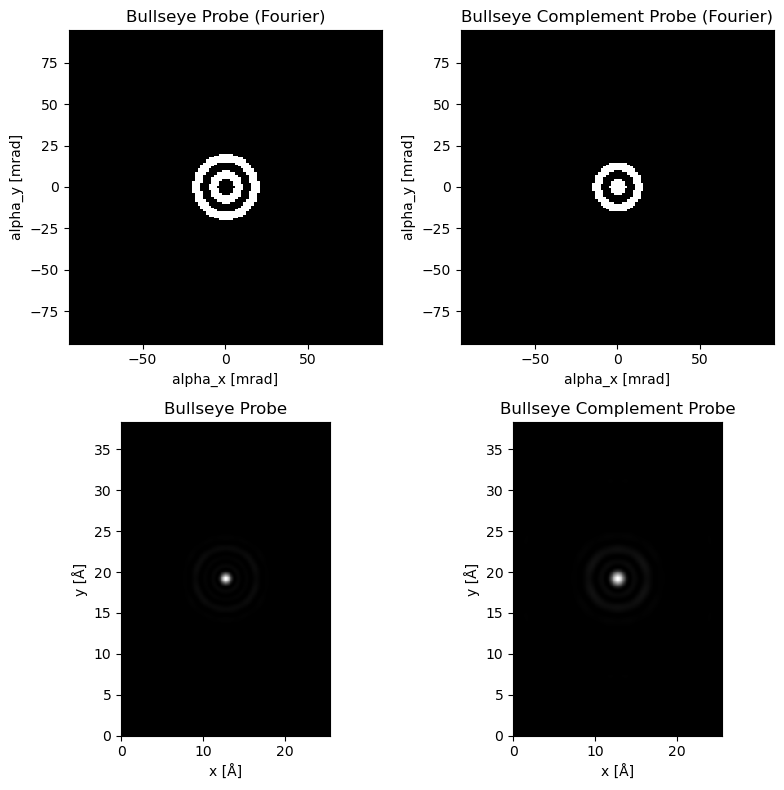

In [43]:
from abtem import CTF
from abtem.device import get_array_module
from typing import Mapping

class Bullseye_CTF(CTF):
    
    def __init__(self,
                 num_bars,
                 complementary: bool = False,
                 semiangle_cutoff: float = np.inf, 
                 energy: float = None, 
                 parameters: Mapping[str,float] = None):
        
        self._complementary = complementary
        self._num_bars      = num_bars
        super().__init__(semiangle_cutoff=semiangle_cutoff, rolloff=0., energy=energy, parameters=parameters)
        
    def evaluate(self, alpha, phi):
        
        array  = self.evaluate_aberrations(alpha, phi) 
        array *= self.evaluate_aperture(alpha,phi)
        
        xp     = get_array_module(array)
        alpha  = xp.array(alpha)*1000.
        
        if self._complementary:
            array *= xp.sin(2*np.pi*alpha*self._num_bars/self.semiangle_cutoff) >= 0.
        else:
            array *= xp.sin(2*np.pi*alpha*self._num_bars/self.semiangle_cutoff) < 0.
                
        return array
    
bullseye_ctf            = Bullseye_CTF(2,
                                       semiangle_cutoff=20,
                                       energy=80e3)

bullseye_complent_ctf   = Bullseye_CTF(2,
                                       complementary=True,
                                       semiangle_cutoff=20,
                                       energy=80e3)

bullseye_probe          = Probe(energy=80e3,ctf=bullseye_ctf)
bullseye_probe.match_grid(padded_potential)
bullseye_complent_probe = Probe(energy=80e3,ctf=bullseye_complent_ctf)
bullseye_complent_probe.match_grid(padded_potential)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (8,8))

bullseye_probe.build().diffraction_pattern().show(ax=ax1,title='Bullseye Probe (Fourier)')
bullseye_complent_probe.build().diffraction_pattern().show(ax=ax2,title='Bullseye Complement Probe (Fourier)')
bullseye_probe.show(ax=ax3,title='Bullseye Probe')
bullseye_complent_probe.show(ax=ax4,title='Bullseye Complement Probe')

fig.tight_layout();

We then simulate 4DSTEM experiments for each of the probes independently, and incoherently sum the diffraction pattern intensities with a 1:3 ratio:

In [44]:
pixelated_measurement_padded_downsampled_bullseye            = bullseye_probe.scan(gridscan_padded, pixelated_detector_padded_downsampled, padded_potential)
pixelated_measurement_padded_downsampled_bullseye_complement = bullseye_complent_probe.scan(gridscan_padded, pixelated_detector_padded_downsampled, padded_potential)
pixelated_measurement_padded_downsampled_incoherent          = (0.25*pixelated_measurement_padded_downsampled_bullseye + 
                                                                0.75*pixelated_measurement_padded_downsampled_bullseye_complement)

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

Scan:   0%|          | 0/378 [00:00<?, ?it/s]

To reconstruct this, we will introduce a new object called `MixedStatePtychographicOperator`.  
This accepts an additional initialization parameter `num_probes` and two additional reconstruction parameters:
- `warmup_update_steps`: Number of Regularized-PIE update steps to perform before switching to the Mixed-State PIE algorith  
  _Note:_ this accepts update steps, **not** iterations, to allow for a finer control
  
But first, let's use this parameter to evaluate how poorly vanilla Regularized-PIE would perform:

In [49]:
from abtem.reconstruct import MixedStatePtychographicOperator

mixed_states_ptycho_operator = MixedStatePtychographicOperator(pixelated_measurement_padded_downsampled_incoherent,
                                                               energy=80e3,
                                                               semiangle_cutoff=10,
                                                               num_probes=2,
                                                               device='gpu',
                                                               parameters={'object_px_padding':(64,64)}).preprocess()

objects_08, probes_08, positions_08, sse_08  = mixed_states_ptycho_operator.reconstruct(max_iterations = 20,
                                                                                        verbose=True,
                                                                                        random_seed=1,
                                                                                        return_iterations=True,
                                                                                        warmup_update_steps = mixed_states_ptycho_operator._num_diffraction_patterns*20)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 7560 steps
--Mixed-State PIE for 0 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0 , SSE = 9.270e-07
----Iteration 1 , SSE = 5.502e-07
----Iteration 2 , SSE = 5.099e-07
----Iteration 3 , SSE = 4.738e-07
----Iteration 4 , SSE = 4.586e-07
----Iteration 5 , SSE = 4.428e-07
----Iteration 6 , SSE = 4.352e-07
----Iteration 7 , SSE = 4.270e-07
----Iteration 8 , SSE = 4.219e-07
----Iteration 9 , SSE = 4.184e-07
----Iteration 10, SSE = 4.184e-07
----Iteration 11, SSE = 4.021e-07
----Iteration 12, SSE = 4.075e-07
----Iteration 13, SSE = 3.982e-07
----Iteration 14, SSE = 4.014e-07
----Iteration 15, SSE = 3.937e-07
----Iteration 16, SSE = 3.906e-07
----Iteration 17, SSE = 3.838e-07
----Iteration 18, SSE = 3.880e-07
----Iteration 19, SSE = 3.882e-07


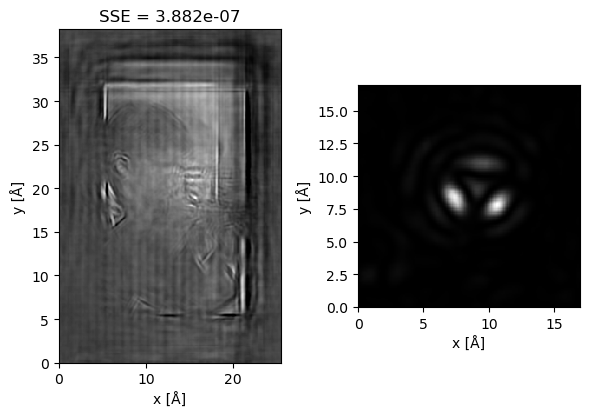

In [53]:
vmin = np.amin(np.angle(objects_08[-1].array[64:-64,64:-64]))
vmax = np.amax(np.angle(objects_08[-1].array[64:-64,64:-64]))
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (6,6))
objects_08[-1].angle().show(ax=ax1,vmin=vmin,vmax=vmax,title=f"SSE = {float(sse_08[-1]):.3e}")
probes_08[-1][0].intensity().show(ax=ax2)
fig.tight_layout()

Let's see how much better the Mixed-State PIE algorithm performs:

In [54]:
mixed_states_ptycho_operator = MixedStatePtychographicOperator(pixelated_measurement_padded_downsampled_incoherent,
                                                               energy=80e3,
                                                               semiangle_cutoff=10,
                                                               num_probes=2,
                                                               device='gpu',
                                                               parameters={'object_px_padding':(64,64)}).preprocess()

objects_09, probes_09, positions_09, sse_09  = mixed_states_ptycho_operator.reconstruct(max_iterations = 20,
                                                                                        verbose=True,
                                                                                        random_seed=1,
                                                                                        warmup_update_steps = 0,
                                                                                        return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 0 steps
--Mixed-State PIE for 7560 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.012e-06
----Iteration 1 , SSE = 5.866e-07
----Iteration 2 , SSE = 5.109e-07
----Iteration 3 , SSE = 4.505e-07
----Iteration 4 , SSE = 4.035e-07
----Iteration 5 , SSE = 3.486e-07
----Iteration 6 , SSE = 3.115e-07
----Iteration 7 , SSE = 2.833e-07
----Iteration 8 , SSE = 2.608e-07
----Iteration 9 , SSE = 2.408e-07
----Iteration 10, SSE = 2.232e-07
----Iteration 11, SSE = 2.010e-07
----Iteration 12, SSE = 1.880e-07
----Iteration 13, SSE = 1.741e-07
----Iteration 14, SSE = 1.579e-07
----Iteration 15, SSE = 1.481e-07
----Iteration 16, SSE = 1.390e-07
----Iteration 17, SSE = 1.297e-07
----Iteration 18, SSE = 1.225e-07
----Iteration 19, SSE = 1.152e-07


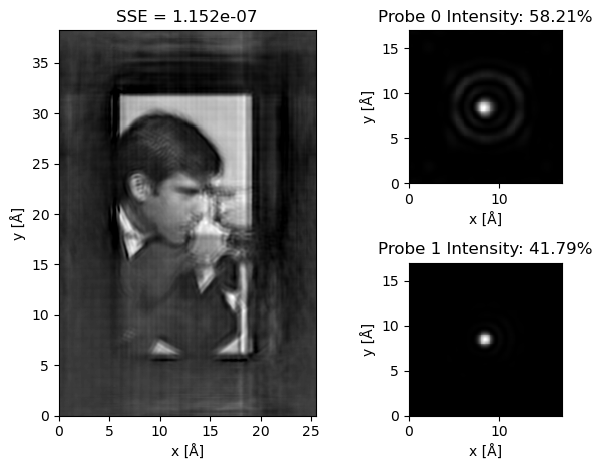

In [55]:
vmin = np.amin(np.angle(objects_09[-1].array[64:-64,64:-64]))
vmax = np.amax(np.angle(objects_09[-1].array[64:-64,64:-64]))

probe_intensity_ratios  = np.sum([probe.intensity().array for probe in probes_09[-1]],axis=(-2,-1))
probe_intensity_ratios /= np.sum(probe_intensity_ratios)/100

fig, axd = plt.subplot_mosaic([['left', 'top-right'],['left', 'bottom-right']],constrained_layout=True)
objects_09[-1].angle().show(ax=axd['left'],vmin=vmin,vmax=vmax,title=f"SSE = {float(sse_09[-1]):.3e}")
probes_09[-1][0].intensity().show(ax=axd['top-right'],title=f'Probe 0 Intensity: {probe_intensity_ratios[0]:.2f}%')
probes_09[-1][1].intensity().show(ax=axd['bottom-right'],title=f'Probe 1 Intensity: {probe_intensity_ratios[1]:.2f}%')
fig.tight_layout()

Even though this is considerably better - the reconstructed probes don't have the same intensity ratios as the simulation.  
We can do even better by using the second keyword parameter in `.reconstruct()`, to orthogonalize our probes (with some frequency. here set to each update step but this is less important)

In [56]:
mixed_states_ptycho_operator = MixedStatePtychographicOperator(pixelated_measurement_padded_downsampled_incoherent,
                                                               energy=80e3,
                                                               semiangle_cutoff=10,
                                                               num_probes=2,
                                                               device='gpu',
                                                               parameters={'object_px_padding':(64,64)}).preprocess()

objects_09, probes_09, positions_09, sse_09  = mixed_states_ptycho_operator.reconstruct(max_iterations = 20,
                                                                                        verbose=True,
                                                                                        random_seed=1,
                                                                                        warmup_update_steps = 0,
                                                                                        probe_orthogonalization_frequency = 1,
                                                                                        return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 0 steps
--Mixed-State PIE for 7560 steps
--Probe correction is enabled


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

----Iteration 0 , SSE = 9.952e-07
----Iteration 1 , SSE = 5.398e-07
----Iteration 2 , SSE = 4.925e-07
----Iteration 3 , SSE = 4.438e-07
----Iteration 4 , SSE = 3.945e-07
----Iteration 5 , SSE = 3.440e-07
----Iteration 6 , SSE = 3.061e-07
----Iteration 7 , SSE = 2.741e-07
----Iteration 8 , SSE = 2.463e-07
----Iteration 9 , SSE = 2.284e-07
----Iteration 10, SSE = 2.089e-07
----Iteration 11, SSE = 1.837e-07
----Iteration 12, SSE = 1.694e-07
----Iteration 13, SSE = 1.597e-07
----Iteration 14, SSE = 1.492e-07
----Iteration 15, SSE = 1.443e-07
----Iteration 16, SSE = 1.350e-07
----Iteration 17, SSE = 1.242e-07
----Iteration 18, SSE = 1.173e-07
----Iteration 19, SSE = 1.097e-07


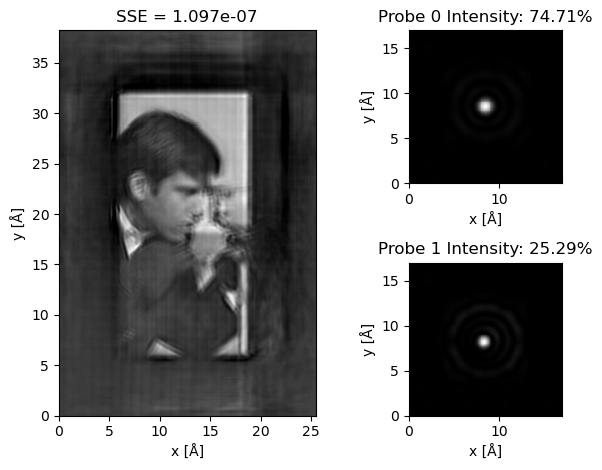

In [57]:
vmin = np.amin(np.angle(objects_09[-1].array[64:-64,64:-64]))
vmax = np.amax(np.angle(objects_09[-1].array[64:-64,64:-64]))

probe_intensity_ratios  = np.sum([probe.intensity().array for probe in probes_09[-1]],axis=(-2,-1))
probe_intensity_ratios /= np.sum(probe_intensity_ratios)/100

fig, axd = plt.subplot_mosaic([['left', 'top-right'],['left', 'bottom-right']],constrained_layout=True)
objects_09[-1].angle().show(ax=axd['left'],vmin=vmin,vmax=vmax,title=f"SSE = {float(sse_09[-1]):.3e}")
probes_09[-1][0].intensity().show(ax=axd['top-right'],title=f'Probe 0 Intensity: {probe_intensity_ratios[0]:.2f}%')
probes_09[-1][1].intensity().show(ax=axd['bottom-right'],title=f'Probe 1 Intensity: {probe_intensity_ratios[1]:.2f}%')
fig.tight_layout()

Indeed, our reconstructed probes have almost precisely the simulated ratios and our reconstruction error is lower.

# Electrostatic & Magnetic Phase Objects

We demonstrate the last two algorithms using more realistic simulations of an STO slab

## Electrostatic Phase Contribution

We wish to reconstruct the projected electrostatic potential contributions to the Aharonov-Bohm phase shift given by:

$$
\begin{align}
    \phi_e(\boldsymbol{r}_\bot) = \frac{e}{\hbar v}\int_L V(\boldsymbol{r}_{\bot},z) dz 
\end{align}
$$

We consider a (thin) slab of [110] STO:

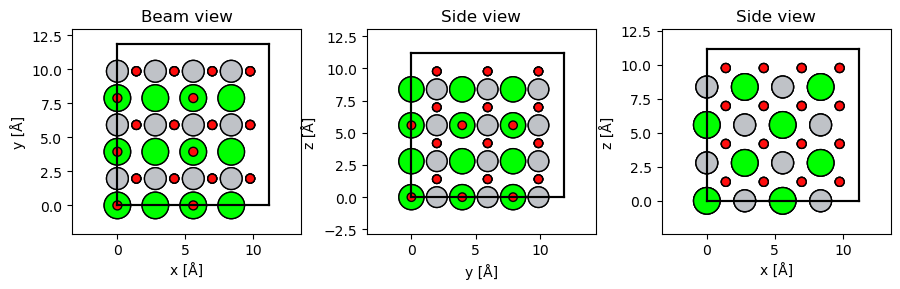

In [59]:
from ase.io import read
from ase import Atoms
from ase.build import surface
from matplotlib import pyplot as plt

STO_unit_cell   = read('data/SrTiO3.cif')
STO_atoms       = surface(STO_unit_cell, (1,1,0), 4, periodic=True)*(2,3,1)

from abtem import show_atoms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,3))

show_atoms(STO_atoms, ax = ax1, title = 'Beam view')
show_atoms(STO_atoms, ax = ax2, plane = 'yz', title = 'Side view')
show_atoms(STO_atoms, ax = ax3, plane = 'xz', title = 'Side view')

fig.tight_layout();

We'll use `FrozenPhonons` to broaden our potentials to simulate finite temperature.

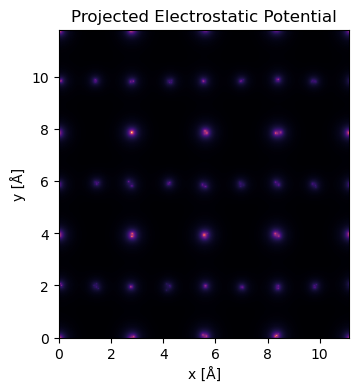

In [60]:
from abtem import FrozenPhonons, Potential

frozen_phonons          = FrozenPhonons(STO_atoms, 1024, {'Sr' : .05, 'Ti' : .05, 'O' : .05}, seed=1)
electrostatic_potential = Potential(frozen_phonons,
                                    sampling=0.02,
                                    device='gpu',
                                    projection='infinite',
                                    parametrization='kirkland').build()

electrostatic_potential.project().show(cmap='magma',figsize=(4,4),title='Projected Electrostatic Potential');

We'll use a fairly aberrated probe for our simulations:

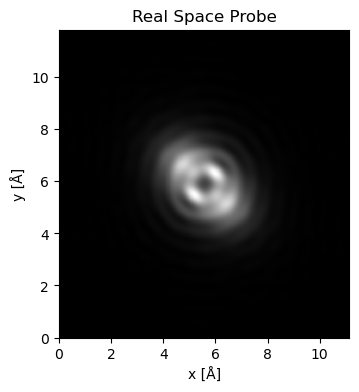

In [61]:
ctf             = CTF(parameters={'C10': -75,'C12': 20, 'phi12': 0.785,'C30':-7e4},semiangle_cutoff=24)
probe           = Probe(semiangle_cutoff=24,
                        energy=200e3,
                        ctf=ctf,
                        device='gpu')
probe.match_grid(electrostatic_potential)
probe.show(figsize=(4,4),title='Real Space Probe');

We perform the 4DSTEM simulation and check how our HAADF looks like:

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

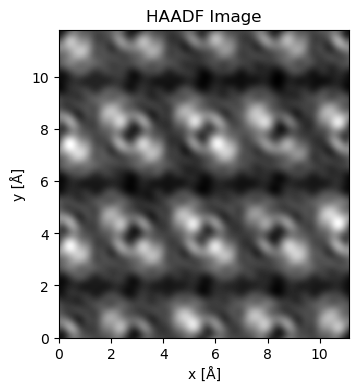

In [63]:
from abtem.detect import AnnularDetector

pixelated_detector  = PixelatedDetector(max_angle=120)
gridscan            = GridScan((0,0), electrostatic_potential.extent, sampling = 0.9*probe.ctf.nyquist_sampling)
measurement         = probe.scan(gridscan, pixelated_detector, electrostatic_potential)

haadf_detector_measurement   = AnnularDetector(inner=24,outer=120).integrate(measurement)
haadf_detector_measurement   = haadf_detector_measurement.interpolate(electrostatic_potential.sampling)

haadf_detector_measurement.show(figsize=(4,4),title='HAADF Image');

We will start by using the `RegularizedPtychographicOperator` again:

In [64]:
electrostatic_potential_ptycho_operator = RegularizedPtychographicOperator(measurement,
                                                                           semiangle_cutoff=24,
                                                                           energy=200e3,
                                                                           device='gpu',
                                                                           parameters={'object_px_padding':(0,0)}).preprocess()

objects_10, probes_10, positions_10, sse_10 = electrostatic_potential_ptycho_operator.reconstruct(max_iterations = 5,
                                                                                                  verbose=True,
                                                                                                  random_seed=1,
                                                                                                  return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 11750 steps
--Probe correction is enabled


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0, SSE = 1.643e-06
----Iteration 1, SSE = 1.280e-07
----Iteration 2, SSE = 7.585e-08
----Iteration 3, SSE = 7.327e-08
----Iteration 4, SSE = 7.186e-08


This is quite good, the regularized e-PIE algorithm is effectively converged after only a couple of iterations and has corrected all aberrations!

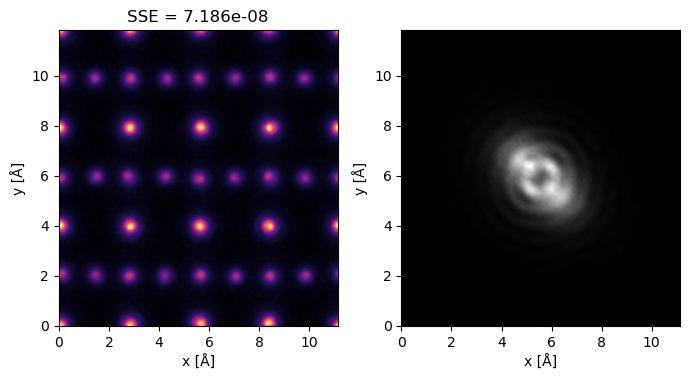

In [65]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (7,7))
objects_10[-1].angle().interpolate(electrostatic_potential.sampling).show(ax=ax1,cmap='magma',title=f"SSE = {float(sse_10[-1]):.3e}")
probes_10[-1].intensity().interpolate(electrostatic_potential.sampling).show(ax=ax2)
fig.tight_layout()

## Multislice Reconstructions

Note that while our reconstructions so far have largely been successful, they relied on the multiplicative assumption for our exit waves: 

$$
\psi_{j \boldsymbol{r}} = P_{\boldsymbol{r}} \times O_{\boldsymbol{r}-\boldsymbol{R}_j}
$$

This breaks down for thick samples, and multislice ptychography accounts for this including propagation in its forward model:

$$
\begin{aligned}
\psi_{j \boldsymbol{r}}^n &= P^n_{\boldsymbol{r}} \times O^n_{\boldsymbol{r}-\boldsymbol{R}_j} \\
P^{n+1}_{\boldsymbol{r}}  &= \mathrm{Prop}_{\Delta Z_n}\left[ \psi_{j \boldsymbol{r}}^n \right]
\end{aligned}
$$

First, let's see Regularized-PIE breakdown already for a sample only 3 times as thick (~3.5 nms) 

In [66]:
STO_atoms_thick      = STO_atoms *(1,1,3)
frozen_phonons_thick = FrozenPhonons(STO_atoms_thick, 1024, {'Sr' : .05, 'Ti' : .05, 'O' : .05}, seed=1)
potential_thick      = Potential(frozen_phonons_thick,
                                 sampling=0.02,
                                 device='gpu',
                                 projection='infinite',
                                 parametrization='kirkland').build()

measurement_thick    = probe.scan(gridscan,pixelated_detector,potential_thick)

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

In [67]:
msrpie_reconstruction_ptycho_operator = RegularizedPtychographicOperator(measurement_thick,
                                                                         semiangle_cutoff=24,
                                                                         energy=200e3,
                                                                         device='gpu',
                                                                         parameters={'object_px_padding':(0,0)}).preprocess()

objects_11, probes_11, positions_11, sse_11 = msrpie_reconstruction_ptycho_operator.reconstruct(max_iterations = 5,
                                                                                                verbose=True,
                                                                                                random_seed=1,
                                                                                                return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 11750 steps
--Probe correction is enabled


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0, SSE = 3.720e-06
----Iteration 1, SSE = 1.807e-06
----Iteration 2, SSE = 1.795e-06
----Iteration 3, SSE = 1.791e-06
----Iteration 4, SSE = 1.776e-06


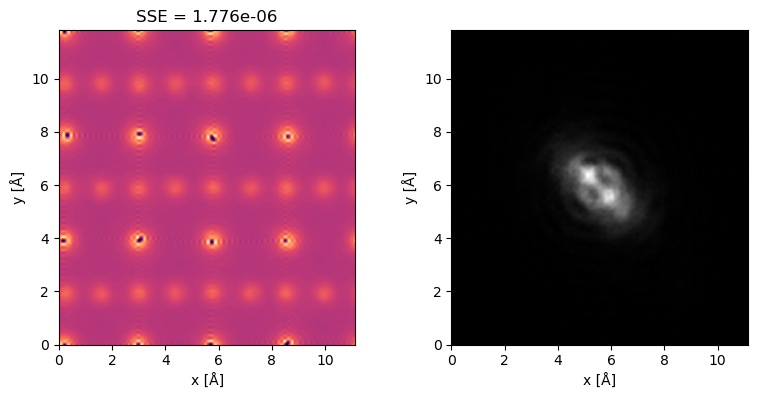

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_11[-1].angle().interpolate(potential_thick.sampling).show(cmap='magma',ax=ax1,title=f"SSE = {float(sse_11[-1]):.3e}")
probes_11[-1].intensity().interpolate(potential_thick.sampling).show(ax=ax2)

fig.tight_layout();

Indeed, the e-PIE algorithm does pretty poorly on the thicker sample.  
Let's see if multislice-PIE performs better. We'll use three evenly-spaced slices.

For this, we introduce another object called `MultislicePtychographicOperator`, which accepts two additional parameters: `num_slices` and `slice_thicknesses`

In [74]:
from abtem.reconstruct import MultislicePtychographicOperator

slice_thicknesses = STO_atoms_thick.cell.lengths()[-1]/3
multislice_reconstruction_ptycho_operator = MultislicePtychographicOperator(measurement_thick,
                                                                            semiangle_cutoff=24,
                                                                            energy=200e3,
                                                                            num_slices = 3,
                                                                            slice_thicknesses = slice_thicknesses,
                                                                            device='gpu',
                                                                            parameters={'object_px_padding':(0,0)}).preprocess()

objects_12, probes_12, positions_12, sse_12 = multislice_reconstruction_ptycho_operator.reconstruct(max_iterations = 5,
                                                                                                    verbose=True,
                                                                                                    random_seed=1,
                                                                                                    return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Multislice PIE for 11750 steps
--Probe correction is enabled


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0, SSE = 2.627e-06
----Iteration 1, SSE = 4.181e-07
----Iteration 2, SSE = 3.419e-07
----Iteration 3, SSE = 2.783e-07
----Iteration 4, SSE = 2.561e-07


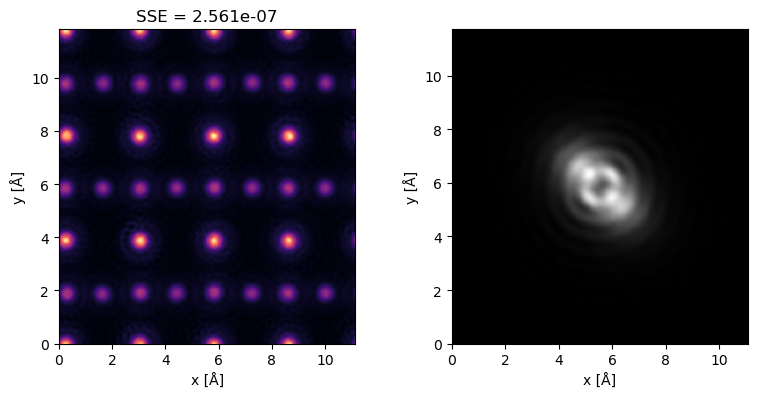

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_12[-1].angle().sum(0).interpolate(potential_thick.sampling).show(cmap='magma',ax=ax1,title=f"SSE = {float(sse_12[-1]):.3e}")
probes_12[-1][0].intensity().interpolate(potential_thick.sampling).show(ax=ax2)

fig.tight_layout();

This is indeed significantly better, albeit more computationally intensive (and often numerically challenging to converge)

## Simultaneous Reconstruction of Electrostatic and Magnetic Phase Contributions

Suppose we additionally wanted to reconstruct the out-of-plane magnetic vector potential contribution to the Aharonov-Bohm phase shift given by:

$$
\begin{align}
    \phi(\boldsymbol{r}_\bot) &= \phi_e(\boldsymbol{r}_\bot)+\phi_m(\boldsymbol{r}_\bot) \notag \\
    &= \frac{e}{\hbar v}\int_L V(\boldsymbol{r}_{\bot},z) dz -\frac{e}{\hbar}\int_L\boldsymbol{A}(\boldsymbol{r}_{\bot},z)\cdot d\boldsymbol{r}
\end{align}
$$

Since the phases enter the multislice transmission function as follows:

$$
\begin{aligned}
T &= \exp{\left[-i \sigma V(r)\right]} \times \exp{\left[-i A(r)\right]} \\
  &= \exp{\left[-i \sigma \left[ V(r) + A(r)/\sigma \right]\right]}
\end{aligned}
$$

we will 'hijack' the `PotentialArray` object to model a dummy magnetic vector potential.  
_Note:_ we'll need to divide by the interaction parameter $\sigma$, to ensure our hack works properly.

For the dummy magnetic vector potential, we'll use two gaussians with opposite sign and asymmetric amplitudes:

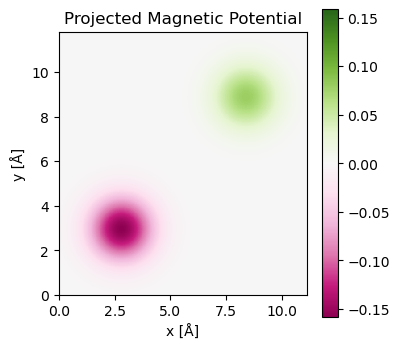

In [77]:
import cupy as cp
from cupyx.scipy.special import erf
from abtem.measure import Calibration

def projected_gaussian_potential(x,y,
                                 z0=10.,z1=0.,
                                 l=10.,w=10.,t=10.,
                                 sigma=1.,asymmetry=2.):
    return (
        asymmetry*(
            cp.exp(-((w-4*y)**2+(l-4*x)**2)/(32*sigma**2))*(
                erf((t-4*z0)/(4*cp.sqrt(2)*sigma))-
                erf((t-4*z1)/(4*cp.sqrt(2)*sigma))
            )
        )+(
            cp.exp(-(9*l**2+9*w**2-24*l*x - 24*w*y+16*(x**2+y**2))/(32*sigma**2))*(
                erf((4*z0-3*t)/(4*cp.sqrt(2)*sigma))-
                erf((4*z1-3*t)/(4*cp.sqrt(2)*sigma))
            )
        )
    )/(4*asymmetry*cp.pi*sigma**2)

def match_grid(potential):
    gx, gy    = potential.gpts
    lx, ly    = potential.extent

    return cp.meshgrid(
        cp.linspace(0.,lx,gx,endpoint=False),
        cp.linspace(0.,ly,gy,endpoint=False),
        indexing='ij'
    )

def get_cumulative_thicknesses(potential):
    return np.flipud(np.cumsum(np.insert(potential.slice_thicknesses,0,0)))

projected_gaussian_calibrations = tuple(Calibration(0., d, 'Å', name, endpoint=False) 
                                        for name, d in zip(('x','y'),electrostatic_potential.sampling))

x,y                             = match_grid(electrostatic_potential)
l,w,t                           = STO_atoms.cell.lengths()
projected_gaussian_measurement  = Measurement(projected_gaussian_potential(x,y,
                                                                           z0=t,z1=0,
                                                                           l=l,w=w,t=t,
                                                                           sigma=1.0,asymmetry=2.
                                                                          ),
                                              projected_gaussian_calibrations)

cmin                            = np.amin(projected_gaussian_measurement.array)
projected_gaussian_measurement.show(cmap='PiYG',cbar=True,vmin=cmin,vmax=-cmin,figsize=(4,4),
                                    title='Projected Magnetic Potential');

In [78]:
from abtem.utils import energy2sigma

cumulative_thicknesses           = get_cumulative_thicknesses(electrostatic_potential)
magnetic_potential               = cp.empty(electrostatic_potential.array.shape)

for slice_id in range(electrostatic_potential.num_slices):
    magnetic_potential[slice_id] = projected_gaussian_potential(x,y,
                                                                z0=cumulative_thicknesses[slice_id],
                                                                z1=cumulative_thicknesses[slice_id+1],
                                                                l=l,w=w,t=t,
                                                                sigma=1.0,asymmetry=2.)

magnetic_potential              /= energy2sigma(probe.energy)

We'll perform two additional 4DSTEM simulations:
1. One with a positive magnetic vector potenial ('measurement_forward')
2. One with a negative magnetic vector potential ('measurement_reverse')

In [79]:
modified_potential_forward         = electrostatic_potential.copy()
modified_potential_forward._array += magnetic_potential

measurement_forward                = probe.scan(gridscan,
                                                pixelated_detector,
                                                modified_potential_forward)

modified_potential_reverse         = electrostatic_potential.copy()
modified_potential_reverse._array -= magnetic_potential

measurement_reverse                = probe.scan(gridscan,
                                                pixelated_detector,
                                                modified_potential_reverse)

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

In theory, we could do two independent Regularized-PIE reconstructions for `measurement_forward` and `measurement_reverse` and then use the following relationship to separate the electrostatic and magnetic phase contributions:

$$
\begin{aligned}
\phi_e &= \left(\phi^{(\mathrm{forward})} + \phi^{(\mathrm{reverse})}\right)/2 \\
\phi_m &= \left(\phi^{(\mathrm{forward})} - \phi^{(\mathrm{reverse})}\right)/2
\end{aligned}
$$

In [82]:
forward_measurement_ptycho_operator = RegularizedPtychographicOperator(measurement_forward,
                                                                       semiangle_cutoff=24,
                                                                       energy=200e3,
                                                                       device='gpu',
                                                                       parameters={'object_px_padding':(0,0)}).preprocess()

objects_13, probes_13, positions_13, sse_13 = forward_measurement_ptycho_operator.reconstruct(max_iterations = 10,
                                                                                              verbose=False,
                                                                                              random_seed=1,
                                                                                              return_iterations=True)

reverse_measurement_ptycho_operator = RegularizedPtychographicOperator(measurement_reverse,
                                                                       semiangle_cutoff=24,
                                                                       energy=200e3,
                                                                       device='gpu',
                                                                       parameters={'object_px_padding':(0,0)}).preprocess()

objects_14, probes_14, positions_14, sse_14 = reverse_measurement_ptycho_operator.reconstruct(max_iterations = 10,
                                                                                              verbose=False,
                                                                                              random_seed=1,
                                                                                              return_iterations=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

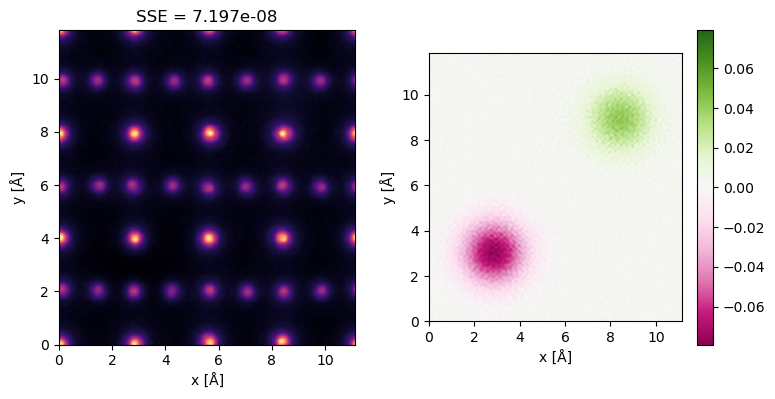

In [90]:
electrostatic_object = (objects_13[-1].angle()+objects_14[-1].angle())/2
magnetic_object      = (objects_13[-1].angle()-objects_14[-1].angle())/2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

electrostatic_object.interpolate(electrostatic_potential.sampling).show(cmap='magma',
                                                                        ax=ax1,
                                                                        title=f"SSE = {float((sse_14[-1]+sse_13[-1])/2):.3e}")

cmin_subtraction = np.amin(magnetic_object.array)

magnetic_object.interpolate(electrostatic_potential.sampling).show(cmap='PiYG',
                                                                   cbar=True,
                                                                   vmin=cmin_subtraction,
                                                                   vmax=-cmin_subtraction,
                                                                   ax=ax2)

fig.tight_layout();

This works reasonably well, however since the magnetic vector potential is so much smaller compared to the electrostatic potential - we are amplifying our noise by subtracting our two reconstructions.

Instead, we can use our physics-based intuition of the forward models to modify our exit-wave and update-rule formulations to jointly-reconstruct both objects using the two sets of diffraction patterns:

$$
\begin{aligned}
\psi_{j \boldsymbol{r}} &= P^{\psi}_{\boldsymbol{r}} \times V_{\boldsymbol{r}-\boldsymbol{R}_j} \times M_{\boldsymbol{r}-\boldsymbol{R}_j} \\
\phi_{j \boldsymbol{r}} &= P^{\phi}_{\boldsymbol{r}} \times V_{\boldsymbol{r}-\boldsymbol{R}_j} \times M^*_{\boldsymbol{r}-\boldsymbol{R}_j}
\end{aligned}
$$

In [85]:
from abtem.reconstruct import SimultaneousPtychographicOperator

simultaneous_reconstruction_ptycho_operator = SimultaneousPtychographicOperator((measurement_forward,measurement_reverse),
                                                                                 semiangle_cutoff=24,
                                                                                 energy=200e3,
                                                                                 device='gpu',
                                                                                 parameters={'object_px_padding':(0,0)}).preprocess()

objects_15, probes_15, positions_15, sse_15  = simultaneous_reconstruction_ptycho_operator.reconstruct(max_iterations = 10,
                                                                                                       verbose=True,
                                                                                                       random_seed=1,
                                                                                                       return_iterations=True,
                                                                                                       parameters={'step_size_damping_rate':0.75})

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 0 steps
--Simultaneous PIE for 23500 steps
--Probe correction is enabled


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.481e-06
----Iteration 1 , SSE = 3.863e-07
----Iteration 2 , SSE = 1.403e-07
----Iteration 3 , SSE = 5.516e-08
----Iteration 4 , SSE = 5.158e-08
----Iteration 5 , SSE = 5.031e-08
----Iteration 6 , SSE = 4.939e-08
----Iteration 7 , SSE = 4.887e-08
----Iteration 8 , SSE = 4.846e-08
----Iteration 9 , SSE = 4.816e-08


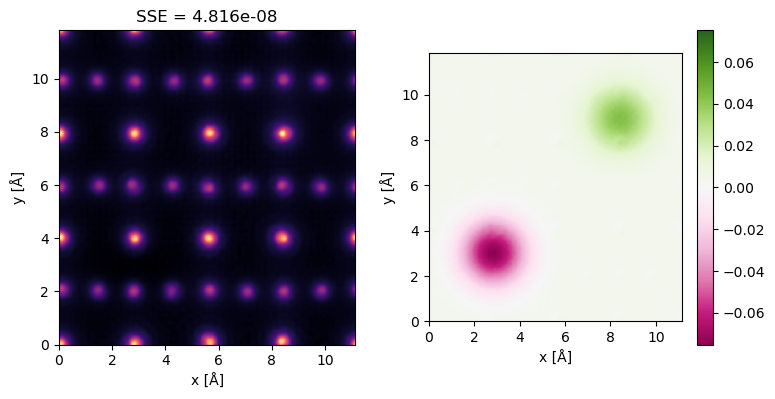

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_15[-1][0].angle().interpolate(electrostatic_potential.sampling).show(cmap='magma',
                                                                        ax=ax1,
                                                                        title=f"SSE = {float(sse_15[-1]):.3e}")

cmin_simultaneous = np.amin(objects_15[-1][1].angle().array)

objects_15[-1][1].angle().interpolate(electrostatic_potential.sampling).show(cmap='PiYG',
                                                                   cbar=True,
                                                                   vmin=cmin_simultaneous,
                                                                   vmax=-cmin_simultaneous,
                                                                   ax=ax2)

fig.tight_layout();

This indeed works significantly better, but we can improve its convergence and speed by taking Regularized-PIE `warmup_update_steps`.  
Also, the `common_probe` reconstruction option allows one to use a single probe for both projections (sacrificing some accuracy for speed):

In [88]:
simultaneous_reconstruction_ptycho_operator_02 = SimultaneousPtychographicOperator((measurement_forward,measurement_reverse),
                                                                                    semiangle_cutoff=24,
                                                                                    energy=200e3,
                                                                                    device='gpu',
                                                                                    parameters={'object_px_padding':(0,0)}).preprocess()

objects_16, probes_16, positions_16, sse_16  = simultaneous_reconstruction_ptycho_operator_02.reconstruct(max_iterations = 10,
                                                                                                          verbose=True,
                                                                                                          random_seed=1,
                                                                                                          common_probe = True,
                                                                                                          warmup_update_steps = simultaneous_reconstruction_ptycho_operator_02._num_diffraction_patterns*5,
                                                                                                          return_iterations=True,
                                                                                                          parameters={'step_size_damping_rate':0.75})

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 11750 steps
--Simultaneous PIE for 11750 steps
--Probe correction is enabled
--Using the first probe as a common probe for both objects


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.668e-06
----Iteration 1 , SSE = 1.327e-07
----Iteration 2 , SSE = 6.222e-08
----Iteration 3 , SSE = 5.622e-08
----Iteration 4 , SSE = 5.323e-08
----Iteration 5 , SSE = 5.222e-08
----Iteration 6 , SSE = 5.037e-08
----Iteration 7 , SSE = 4.956e-08
----Iteration 8 , SSE = 4.892e-08
----Iteration 9 , SSE = 4.847e-08


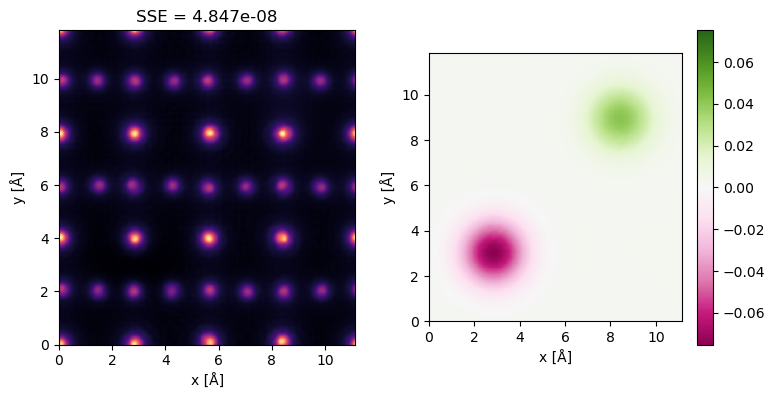

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

objects_16[-1][0].angle().interpolate(electrostatic_potential.sampling).show(cmap='magma',
                                                                        ax=ax1,
                                                                        title=f"SSE = {float(sse_16[-1]):.3e}")

cmin_common = np.amin(objects_16[-1][1].angle().array)

objects_16[-1][1].angle().interpolate(electrostatic_potential.sampling).show(cmap='PiYG',
                                                                   cbar=True,
                                                                   vmin=cmin_simultaneous,
                                                                   vmax=-cmin_simultaneous,
                                                                   ax=ax2)

fig.tight_layout();

# Experimental Datasets

Finally, let's investigate a small MoS$_2$ experimental dataset.  
At a minimum, we require the experiment energy, step size and angular sampling:

In [93]:
from scipy.io import loadmat

rotation_angle                    = 30/180*np.pi
adu_background_cutoff             = 20
adu                               = 149
dataset                           = loadmat('data_mos2_sample.mat')
raw_data                          = np.transpose(dataset['dp'],(3,2,0,1)) # transposes cbed
energy                            = np.squeeze(dataset['voltage']*1e3).item()
semiangle                         = np.squeeze(dataset['alpha_max']).item()

step_size_real_space              = (np.squeeze(dataset['scanStepSize_x']).item(),np.squeeze(dataset['scanStepSize_y']).item())
reciprocal_space_sampling_invang  = np.squeeze(dataset['dk']).item()
reciprocal_space_sampling_mrad    = (energy2wavelength(energy)*1e3*reciprocal_space_sampling_invang,)*2

We can use these properties to set up a `Measurement` object.  
Alternatively, we could pass raw_data directly to the operator, but this allows us to perform some sanity checks by plotting an ADF and PACBED image.

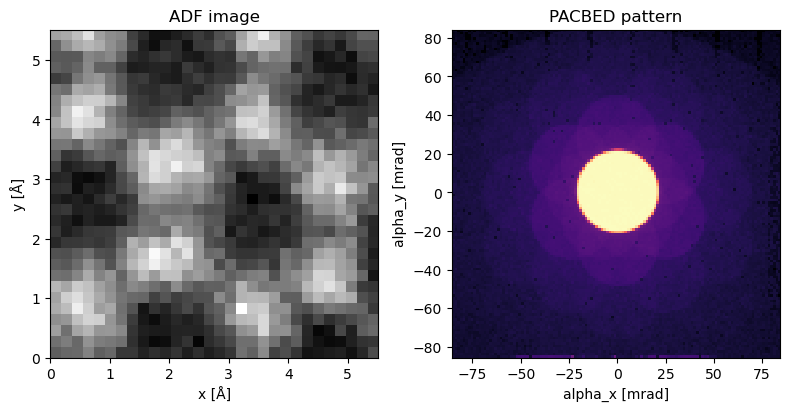

In [97]:
calibrations  = tuple(Calibration(0., d, 'Å', name, endpoint=False) 
                        for name, d in zip(('x','y'),step_size_real_space))
calibrations += tuple(Calibration(-dk*n/2, dk, 'mrad', name, endpoint=False) 
                        for name, dk, n in zip(('alpha_x','alpha_y'),reciprocal_space_sampling_mrad,raw_data.shape[2:]))

raw_data[raw_data<adu_background_cutoff] = 0.
experimental_measurement = Measurement(raw_data,calibrations)
adf                      = AnnularDetector(inner=semiangle,outer=reciprocal_space_sampling_mrad[0]*raw_data.shape[2]/2).integrate(experimental_measurement)
pacbed                   = experimental_measurement.mean(axis=(0,1))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,6))

adf.show(ax=ax1,title='ADF image')
pacbed.show(power=0.25,ax=ax2,cmap='magma',title='PACBED pattern')

fig.tight_layout()

We use a two-probe mixed-state reconstruction algorithm.  
We specify an ROI slightly larger than our CBED patterns (to demonstrate padding), and in contrast to the simulations above do not specify `object_px_padding` directly. Instead, the `.preprocess()` method will pad by half the ROI on each side of the rotated positions.

In [98]:
experimental_ptycho_operator = MixedStatePtychographicOperator(experimental_measurement,
                                                               region_of_interest_shape=(128,128),
                                                               num_probes=2,
                                                               semiangle_cutoff=semiangle,
                                                               energy=energy,
                                                               device='gpu',
                                                               parameters={'background_counts_cutoff': adu_background_cutoff,
                                                                           'counts_scaling_factor':adu,
                                                                           'rotation_angle':rotation_angle}).preprocess()

objects_17, probes_17, positions_17, sse_17  = experimental_ptycho_operator.reconstruct(max_iterations = 50,
                                                                                        verbose=False,
                                                                                        random_seed=1,
                                                                                        return_iterations=True,
                                                                                       )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

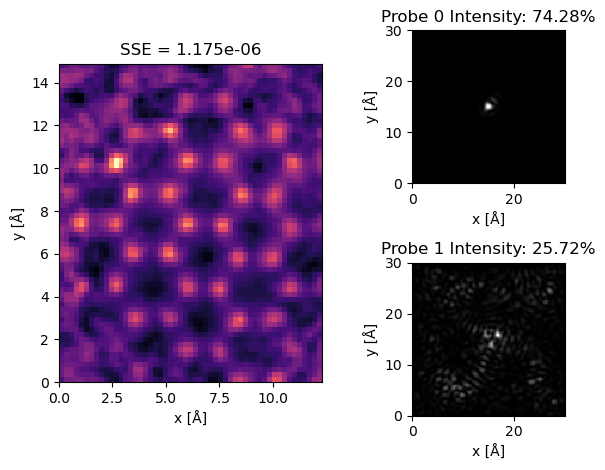

In [99]:
probe_intensity_ratios  = np.sum([probe.intensity().array for probe in probes_17[-1]],axis=(-2,-1))
probe_intensity_ratios /= np.sum(probe_intensity_ratios)/100

fig, axd = plt.subplot_mosaic([['left', 'top-right'],['left', 'bottom-right']],constrained_layout=True)
objects_17[-1].crop(extent=(25,27.5), origin=(12.5,12.5)).angle().show(ax=axd['left'],title=f"SSE = {float(sse_17[-1]):.3e}",cmap='magma')
probes_17[-1][0].intensity().show(ax=axd['top-right'],title=f'Probe 0 Intensity: {probe_intensity_ratios[0]:.2f}%')
probes_17[-1][1].intensity().show(ax=axd['bottom-right'],title=f'Probe 1 Intensity: {probe_intensity_ratios[1]:.2f}%')
fig.tight_layout()

Indeed, this is significantly better than our ADF!  
_Note:_ There's a lot of hyper-parameters (such as update step sizes and regularization) one could tune here, but the default values perform reasonably well